# Cloud Segmentation in Satellite Images

Inspired by Kaggle Notebook : https://www.kaggle.com/code/simple11/cloud-segmentation

In [19]:
# Standard library imports
import os
import random
import time
from pathlib import Path
from datetime import datetime

# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim import lr_scheduler
from torchsummary import summary

# Vision-related imports
from torchvision.models import resnet18, resnet34
from PIL import Image

In [4]:
# Check if the "pytorch_unet.py" file exists
if not os.path.exists("pytorch_unet.py"):
    
    # Check if the "pytorch_unet" directory exists
    if not os.path.exists("pytorch_unet"):
        
        # If the "pytorch_unet" directory does not exist, clone the GitHub repository
        !git clone https://github.com/usuyama/pytorch-unet.git
    
    # Change the current working directory to the "pytorch-unet" directory
    %cd pytorch-unet

Cloning into 'pytorch-unet'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 67 (delta 6), reused 10 (delta 5), pack-reused 55 (from 1)
Receiving objects: 100% (67/67), 338.19 KiB | 6.63 MiB/s, done.
Resolving deltas: 100% (24/24), done.
/home/onyxia/work/damaged-building-detector/pytorch-unet


In [3]:
# Check if a GPU is available; if not, raise an exception
if not torch.cuda.is_available():
    raise Exception("GPU not available. CPU training will be too slow.")

print("Device name:", torch.cuda.get_device_name(0))

Device name: NVIDIA H100 PCIe


In [44]:
class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True, include_nir=False, transform=None):
        super().__init__()
        
        # Loop through the files in the red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        self.include_nir = False
        self.transform = transform
        
    def combine_files(self, r_file: Path, g_dir, b_dir, nir_dir, gt_dir):
        # Combine file paths for different spectral bands into a dictionary
        files = {'red': r_file, 
                 'green': g_dir / r_file.name.replace('red', 'green'),
                 'blue': b_dir / r_file.name.replace('red', 'blue'), 
                 'nir': nir_dir / r_file.name.replace('red', 'nir'),
                 'gt': gt_dir / r_file.name.replace('red', 'gt')}
        return files
                                       
    def __len__(self):
        # Return the number of files in the dataset
        return len(self.files)
     
    def open_as_array(self, idx, invert=False):
        # Open image files as arrays, optionally including NIR channel
        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)
    
        if self.include_nir: # Include Near Infrared channel
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
    
        if invert:
            raw_rgb = raw_rgb.transpose((2, 0, 1))
    
        # Normalize pixel values
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)
    
    def open_mask(self, idx, add_dims=False):
        # Open ground truth mask as an array
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask == 255, 1, 0)
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        # Get an item from the dataset (image and mask)
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.int64)

        if self.transform: # apply transformation to x # data augmentation
            augmented = self.transform(image=x, mask=y)
            x, y = augmented['image'], augmented['mask']
        
        return x, y
    
    def open_as_pil(self, idx):
        # Open an image as a PIL image
        arr = 256 * self.open_as_array(idx)
        return Image.fromarray(arr.astype(np.uint8), 'RGB')
    
    def __repr__(self):
        # Return a string representation of the dataset
        s = 'Dataset class with {} files'.format(self.__len__())
        return s

### Download the 38-Cloud :  Cloud Segmentation in Satellite Images

- run : pip install kaggle 
- Connect to kaggle API (username and API Key via Environmental variable) : export KAGGLE_USERNAME=... and export KAGGLE_KEY=...
- run : kaggle datasets download -d sorour/38cloud-cloud-segmentation-in-satellite-images (12GB)

### Load the 38-Cloud Dataset from S3 Buckets

- run : mc cp s3/mbesnier/diffusion/damage_detection/cloud-segmentation-data . --recursive

In [45]:
base_path = Path('/home/onyxia/work/38-Cloud_training')
data = CloudDataset(base_path/'train_red', 
                    base_path/'train_green', 
                    base_path/'train_blue', 
                    base_path/'train_nir',
                    base_path/'train_gt')
len(data)

8400

In [46]:
data.files[0]

{'red': PosixPath('/home/onyxia/work/38-Cloud_training/train_red/red_patch_414_18_by_23_LC08_L1TP_059014_20160620_20170221_01_T1.TIF'),
 'green': PosixPath('/home/onyxia/work/38-Cloud_training/train_green/green_patch_414_18_by_23_LC08_L1TP_059014_20160620_20170221_01_T1.TIF'),
 'blue': PosixPath('/home/onyxia/work/38-Cloud_training/train_blue/blue_patch_414_18_by_23_LC08_L1TP_059014_20160620_20170221_01_T1.TIF'),
 'nir': PosixPath('/home/onyxia/work/38-Cloud_training/train_nir/nir_patch_414_18_by_23_LC08_L1TP_059014_20160620_20170221_01_T1.TIF'),
 'gt': PosixPath('/home/onyxia/work/38-Cloud_training/train_gt/gt_patch_414_18_by_23_LC08_L1TP_059014_20160620_20170221_01_T1.TIF')}

In [47]:
# Print shapes of image and label at index 2
print(data[2][0].shape, data[2][1].shape)

torch.Size([3, 384, 384]) torch.Size([384, 384])


### Display Data 

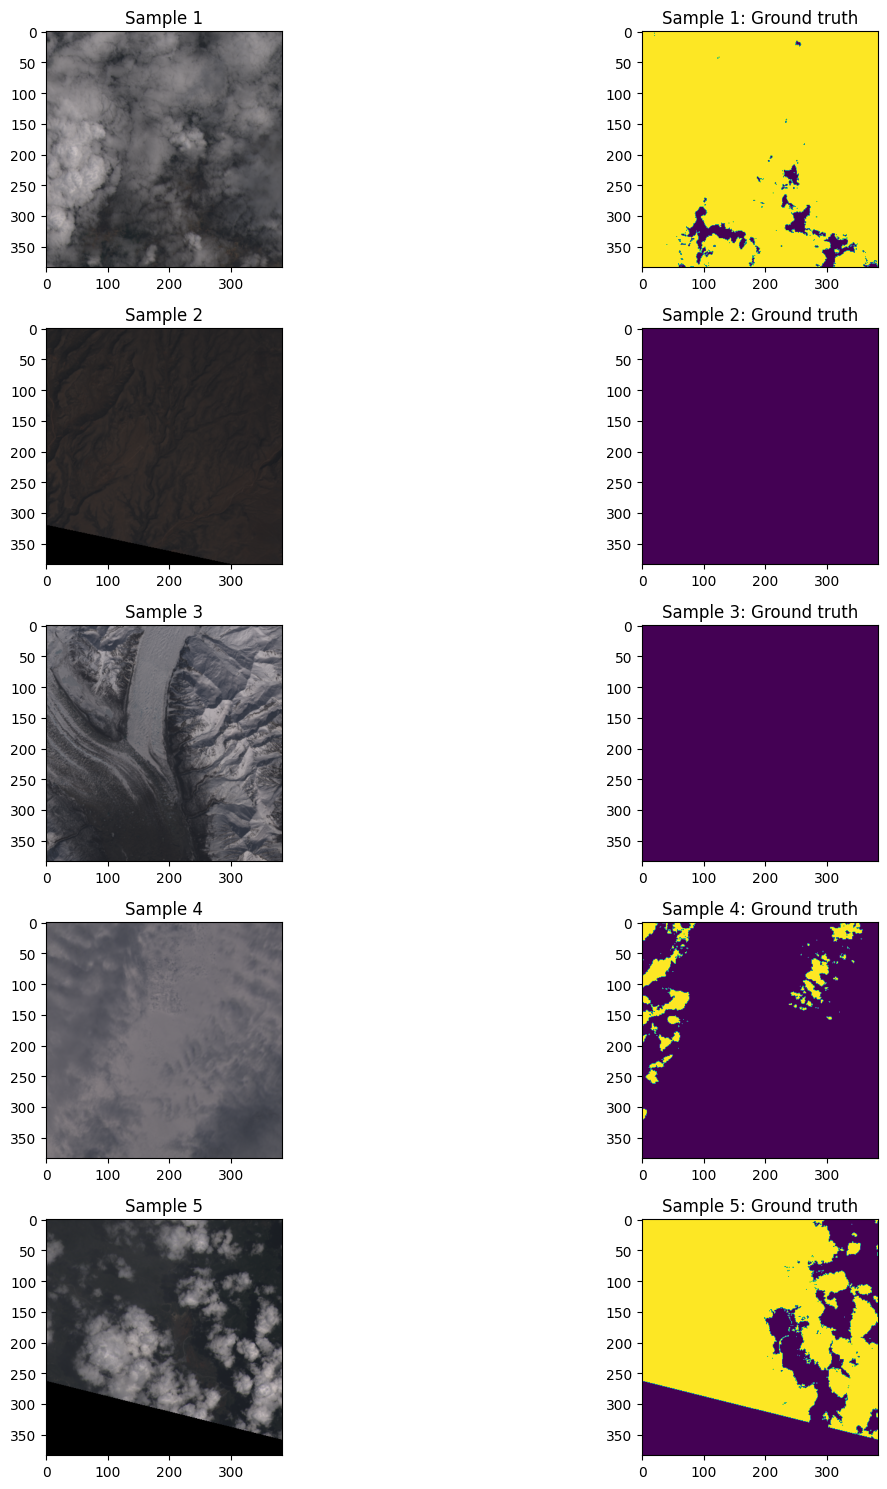

In [48]:
# Create a subplot grid for displaying the images and masks
fig, ax = plt.subplots(5, 2, figsize=(15, 15))

# Generate 5 random sample indices
sample_indices = random.sample(range(len(data)), 5)

# Iterate through the sample indices and display images and masks
for i, idx in enumerate(sample_indices):
    ax[i, 0].imshow(data.open_as_array(idx))
    ax[i, 0].set_title(f'Sample {i + 1}')
    
    ax[i, 1].imshow(data.open_mask(idx))
    ax[i, 1].set_title(f'Sample {i + 1}: Ground truth')

plt.tight_layout()
plt.show()

### Modeling 

In [9]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   

class UNet(nn.Module):

    def __init__(self, n_class, in_channels=3):
        super().__init__()
                
        self.dconv_down1 = double_conv(in_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [10]:
from torchvision.models import resnet34, resnet18

class ResNet_UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=2, pretrained=True):
        super().__init__()
        
        # Modify first layer of ResNet34 to accept custom number of channels
        base_model = resnet18(weights=pretrained)  # Change this line
        base_model.conv1 = torch.nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        self.base_layers = list(base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        
        self.upconv4 = self.expand_block(512, 256)
        self.upconv3 = self.expand_block(256*2, 128)
        self.upconv2 = self.expand_block(128*2, 64)
        self.upconv1 = self.expand_block(64*2, 64)
        self.upconv0 = self.expand_block(64*2, out_channels)
        

    def forward(self, x):

        # Contracting Path
        layer0 = self.layer0(x)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        # Expansive Path
        upconv4 = self.upconv4(layer4)
        upconv3 = self.upconv3(torch.cat([upconv4, layer3], 1))
        upconv2 = self.upconv2(torch.cat([upconv3, layer2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, layer1], 1))
        upconv0 = self.upconv0(torch.cat([upconv1, layer0], 1))

        return upconv0

    def expand_block(self, in_channels, out_channels):
        expand = nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
        )
        return expand

    

### Losses and Metrics

In [20]:
# Metrics 
class MeanPixelAccuracy(nn.Module):
    def __init__(self):
        super(MeanPixelAccuracy, self).__init__()

    def forward(self, pred, target):
        # Calculate pixel-wise accuracy by comparing predicted and ground truth labels
        correct_pixels = (pred.argmax(dim=1) == target.to(pred.device)).float()
        mean_accuracy = correct_pixels.mean()
        return mean_accuracy

class IoUMetric:
    def __init__(self, smooth=1e-6):
        self.smooth = smooth  # Smooth term to prevent division by zero

    def __call__(self, pred, target):
        # pred shape: (batch_size, num_classes, height, width)
        # target shape: (batch_size, height, width)

        # Apply argmax to get predicted class per pixel
        pred = pred.argmax(dim=1)  # shape (batch_size, height, width)

        # Flatten predictions and target for calculation
        pred = pred.view(-1)       # shape (batch_size * height * width,)
        target = target.view(-1)   # shape (batch_size * height * width,)

        # Create a tensor to store IoU for each class
        num_classes = pred.max().item() + 1  # Determine the number of classes from pred
        ious = []

        for cls in range(num_classes):
            pred_cls = (pred == cls).float()  # 1 for pixels in the predicted class, else 0
            target_cls = (target == cls).float()  # 1 for pixels in the target class, else 0

            # Calculate intersection and union
            intersection = (pred_cls * target_cls).sum()
            union = pred_cls.sum() + target_cls.sum() - intersection

            # Compute IoU and add to the list
            iou = (intersection + self.smooth) / (union + self.smooth)
            ious.append(iou)

        # Calculate mean IoU over all classes
        mean_iou = torch.stack(ious).mean()
        
        return mean_iou


class DiceMetric:
    def __init__(self, smooth=1e-6):
        self.smooth = smooth  # Smooth term to prevent division by zero

    def __call__(self, pred, target):
        # pred shape: (batch_size, num_classes, height, width)
        # target shape: (batch_size, height, width)

        # Apply softmax to get probabilities for each class
        pred = pred.softmax(dim=1)  # shape (batch_size, num_classes, height, width)
        
        # Flatten predictions and target across spatial dimensions
        pred = pred.view(pred.size(0), pred.size(1), -1)  # (batch_size, num_classes, height * width)
        target = target.view(target.size(0), 1, -1)       # (batch_size, 1, height * width)

        # Create one-hot encoding for target
        target_one_hot = torch.zeros_like(pred).scatter_(1, target, 1)  # (batch_size, num_classes, height * width)

        # Calculate Dice score for each class
        intersection = (pred * target_one_hot).sum(dim=2)  # sum over pixels
        pred_sum = pred.sum(dim=2)
        target_sum = target_one_hot.sum(dim=2)

        # Compute Dice score for each class
        dice_score = (2 * intersection + self.smooth) / (pred_sum + target_sum + self.smooth)
        
        # Average Dice score over classes
        mean_dice = dice_score.mean()
        
        return mean_dice

# Losses 
# Cross entropy loss : nn.CrossEntropyLoss()
# Dice Loss 
# IoU loss 

class IoULoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(IoULoss, self).__init__()
        self.smooth = smooth  # Smooth term to prevent division by zero

    def forward(self, pred, target):
        # pred shape (batch_size, num_classes, height, width)
        # target shape (batch_size, height, width)
        
        # Apply softmax to get probabilities for each class
        pred = pred.softmax(dim=1)  # shape (batch_size, num_classes, height, width)
        
        # Flatten predictions and target across spatial dimensions
        pred = pred.view(pred.size(0), pred.size(1), -1)  # shape (batch_size, num_classes, height * width)
        target = target.view(target.size(0), 1, -1)       # shape (batch_size, 1, height * width)

        # Create one-hot encoding for target
        target_one_hot = torch.zeros_like(pred).scatter_(1, target, 1)  # shape (batch_size, num_classes, height * width)

        # Calculate intersection and union
        intersection = (pred * target_one_hot).sum(dim=2)  # sum over pixels
        union = pred.sum(dim=2) + target_one_hot.sum(dim=2) - intersection  # sum over pixels
        
        # Compute IoU for each class and batch, add smooth for numerical stability
        iou = (intersection + self.smooth) / (union + self.smooth)
        
        # Average IoU over classes and batch
        iou_loss = 1 - iou.mean()
        
        return iou_loss

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth  # Smooth term to prevent division by zero

    def forward(self, pred, target):
        # pred shape (batch_size, num_classes, height, width), target shape (batch_size, height, width)
        # Apply softmax to pred if needed and flatten the tensors
        pred = pred.softmax(dim=1)  # ensure pred is a probability distribution per class
        
        # Convert to binary mask for Dice computation by treating each class separately
        # Flatten across pixels and batch
        pred = pred.view(pred.size(0), pred.size(1), -1)  # (batch_size, num_classes, height * width)
        target = target.view(target.size(0), 1, -1)       # (batch_size, 1, height * width)
        
        # Create a one-hot target vector (batch_size, num_classes, height * width)
        target_one_hot = torch.zeros_like(pred).scatter_(1, target, 1)

        # Calculate Dice coefficient for each class
        intersection = (pred * target_one_hot).sum(dim=2)
        pred_sum = pred.sum(dim=2)
        target_sum = target_one_hot.sum(dim=2)
        
        # Compute Dice loss
        dice_score = (2 * intersection + self.smooth) / (pred_sum + target_sum + self.smooth)
        dice_loss = 1 - dice_score.mean()  # Mean over classes and batch
        
        return dice_loss

In [21]:
"""### Test Metrics and Losses 
# xb , yb and pred
print("-----Losses-----")

cross_entropy_loss =  nn.CrossEntropyLoss()
print(f'cross entropy loss {cross_entropy_loss(pred, yb)}')

dice_loss = DiceLoss()
print(f'dice loss : {dice_loss(pred=pred, target=yb)}')

iou_loss = IoULoss()
print(f'iou_loss : {iou_loss(pred=pred, target=yb)}')

print("-----Metrics----")
mean_pixel_acc = MeanPixelAccuracy()
print(f'mean_pixel_acc : {mean_pixel_acc(pred=pred,target=yb)}')

iou_metric = IoUMetric()
print(f'iou_metric : {iou_metric(pred=pred, target=yb)}')

dice_metric = DiceMetric()
print(f'dice_metric : {dice_metric(pred=pred, target=yb)}')"""

'### Test Metrics and Losses \n# xb , yb and pred\nprint("-----Losses-----")\n\ncross_entropy_loss =  nn.CrossEntropyLoss()\nprint(f\'cross entropy loss {cross_entropy_loss(pred, yb)}\')\n\ndice_loss = DiceLoss()\nprint(f\'dice loss : {dice_loss(pred=pred, target=yb)}\')\n\niou_loss = IoULoss()\nprint(f\'iou_loss : {iou_loss(pred=pred, target=yb)}\')\n\nprint("-----Metrics----")\nmean_pixel_acc = MeanPixelAccuracy()\nprint(f\'mean_pixel_acc : {mean_pixel_acc(pred=pred,target=yb)}\')\n\niou_metric = IoUMetric()\nprint(f\'iou_metric : {iou_metric(pred=pred, target=yb)}\')\n\ndice_metric = DiceMetric()\nprint(f\'dice_metric : {dice_metric(pred=pred, target=yb)}\')'

In [22]:
def validate(model: nn.Module, dataloader: DataLoader, 
             loss_fns: List[nn.Module], loss_weights: List[float], 
             metric_fns: List[object], device: str, writer: SummaryWriter, epoch: int):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    running_metrics = {metric.__class__.__name__: 0.0 for metric in metric_fns}
    dict_losses = {loss_fn.__class__.__name__: [] for loss_fn in loss_fns}  # Dictionary to store individual losses

    with torch.no_grad():
        for step, (x, y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)

            total_loss = 0  # Reset loss for each batch
            outputs = model(x)

            # Calculate total loss with weights
            for w, loss_fn in zip(loss_weights, loss_fns):
                l = loss_fn(outputs, y)
                total_loss += w * l
                dict_losses[loss_fn.__class__.__name__].append(l.detach().cpu().numpy())  # Store individual loss

            # Calculate Metrics
            for metric_fn in metric_fns:
                metric_res = metric_fn(pred=outputs, target=y)
                running_metrics[metric_fn.__class__.__name__] += metric_res.item() * dataloader.batch_size

            running_loss += total_loss.detach() * dataloader.batch_size

            # Log individual loss to TensorBoard every few steps (e.g., every 10 steps)
            if step % 10 == 0:
                for loss_fn in loss_fns:
                    writer.add_scalar(f'valid/{loss_fn.__class__.__name__}_loss', 
                                      dict_losses[loss_fn.__class__.__name__][-1], 
                                      epoch * len(dataloader) + step)

    # Calculate epoch metrics
    epoch_loss = running_loss / len(dataloader.dataset)
    for metric_name in running_metrics:
        running_metrics[metric_name] /= len(dataloader.dataset)

    return epoch_loss, running_metrics


In [30]:
def train(model: nn.Module, train_dl: DataLoader, valid_dl: DataLoader, 
          loss_fns: List[nn.Module], loss_weights: List[float] = None, 
          optimizer=None, scheduler=None, metric_fns: List[object] = None, 
          epochs=1, experiment_name="experiment", log_dir="runs", 
          verbose=False, device="cuda:0", model_dir="models"):

    #Create a directory for the experiment
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir = os.path.join(log_dir, f"{experiment_name}_{timestamp}")
    print(f'Experiment logs are recoded at {log_dir}')
    # Initialize TensorBoard writer
    writer = SummaryWriter(log_dir)

    # Ensure model directory exists
    os.makedirs(model_dir, exist_ok=True)

    # Check for loss weights and normalize
    if loss_weights is None:
        loss_weights = [1.0 / len(loss_fns)] * len(loss_fns)
    elif np.sum(loss_weights) != 1:
        raise ValueError("The loss weights do not sum to 1!")

    start = time.time()
    model.to(device)  # Move model to specified device

   
    train_loss, valid_loss = [], []
    best_loss = float('inf')
    dict_losses = {loss_fn.__class__.__name__: [] for loss_fn in loss_fns}  # Dictionary to store individual losses

    overall_metrics = {metric.__class__.__name__: [] for metric in metric_fns}

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        print('-' * 10)

        if scheduler:
            scheduler.step()

        for param_group in optimizer.param_groups:
            print("Learning Rate:", param_group['lr'])

        model.train()  # Set model to training mode
        running_loss = 0.0

        # Iterate over training data
        for step, (x, y) in enumerate(train_dl):
            x = x.to(device)
            y = y.to(device)

            total_loss = 0  # Reset loss for each batch
        
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(x)

            # Calculate total loss with weights
            for w, loss_fn in zip(loss_weights, loss_fns):
                l = loss_fn(outputs, y)
                total_loss += w * l
                dict_losses[loss_fn.__class__.__name__].append(l.detach().cpu().numpy())  # Store individual loss

            total_loss.backward()
            optimizer.step()
            
            running_loss += total_loss.detach() * train_dl.batch_size

            # Log individual loss to TensorBoard every few steps (e.g., every 10 steps)
            if step % 10 == 0:
                for loss_fn in loss_fns:
                    writer.add_scalar(f'train/{loss_fn.__class__.__name__}_loss', 
                                      dict_losses[loss_fn.__class__.__name__][-1], 
                                      epoch * len(train_dl) + step)

        # Calculate epoch metrics for training loss
        train_epoch_loss = running_loss / len(train_dl.dataset)
        train_loss.append(train_epoch_loss)

        # Log metrics to TensorBoard
        writer.add_scalar('train/train_loss', train_epoch_loss, epoch)

        # Validation
        valid_epoch_loss, running_metrics = validate(model, valid_dl, loss_fns, loss_weights, metric_fns, device, writer, epoch)
        valid_loss.append(valid_epoch_loss)

        
        # Log validation metrics to TensorBoard
        writer.add_scalar('valid/valid_loss', valid_epoch_loss, epoch)
        for metric_name, metric_value in running_metrics.items():
            writer.add_scalar(f'valid/valid_{metric_name}', metric_value, epoch)

        # Print epoch summary
        print(f'Train Loss: {train_epoch_loss:.4f}')
        print(f'Valid Loss: {valid_epoch_loss:.4f}')
        for metric_name, metric_value in running_metrics.items():
            print(f'{metric_name}: {metric_value:.4f}')
        print('-' * 10)

        # Track best model based on validation loss
        if valid_epoch_loss < best_loss:
            print("Saving best model")
            best_loss = valid_epoch_loss
            # Define the model save path
            model_save_path = os.path.join(model_dir, f"{experiment_name}_{timestamp}_best_model.pth")
            torch.save(model.state_dict(), model_save_path)
            print(f"Best model saved at: {model_save_path}")

        # Store metrics for later analysis
        for metric_name, metric_value in running_metrics.items():
            overall_metrics[metric_name].append(metric_value)

    # Close TensorBoard writer
    writer.close()

    # Print total training time
    time_elapsed = time.time() - start
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    
    return train_loss, valid_loss, overall_metrics


In [31]:
train_ds, valid_ds = torch.utils.data.random_split(data, [0.8, 0.2])

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Model will be trained on {device}")

model = ResNet_UNET(3, 2, pretrained=True)

#Freeze backbone layer
for l in model.base_layers:
    for param in l.parameters():
        param.requires_grad = False


loss_fns = [DiceLoss(), nn.CrossEntropyLoss()]
loss_weights = [0.4, 0.6]
metric_fns = [IoUMetric(), MeanPixelAccuracy(), DiceMetric()]
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1) 

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=False, num_workers=4)

# Train the model
train_loss, valid_loss, overall_metrics = train(
    model, 
    train_dl,
    valid_dl, 
    loss_fns=loss_fns,
    loss_weights=loss_weights,
    optimizer=optimizer_ft, 
    metric_fns=metric_fns,
    log_dir="runs",
    experiment_name='ResNet_Unet',
    epochs=50,
    device=device,
    verbose=True
    )

Model will be trained on cuda:0
Experiment logs are recoded at runs/ResNet_Unet_20241031-224915
Epoch 1/50
----------
Learning Rate: 0.0001
Train Loss: 0.5224
Valid Loss: 0.4738
IoUMetric: 0.8563
MeanPixelAccuracy: 0.9398
DiceMetric: 0.4702
----------
Saving best model
Best model saved at: models/ResNet_Unet_20241031-224915_best_model.pth
Epoch 2/50
----------
Learning Rate: 0.0001
Train Loss: 0.4663
Valid Loss: 0.4535
IoUMetric: 0.8709
MeanPixelAccuracy: 0.9486
DiceMetric: 0.4770
----------
Saving best model
Best model saved at: models/ResNet_Unet_20241031-224915_best_model.pth
Epoch 3/50
----------
Learning Rate: 0.0001
Train Loss: 0.4488
Valid Loss: 0.4406
IoUMetric: 0.8813
MeanPixelAccuracy: 0.9532
DiceMetric: 0.4846
----------
Saving best model
Best model saved at: models/ResNet_Unet_20241031-224915_best_model.pth
Epoch 4/50
----------
Learning Rate: 0.0001
Train Loss: 0.4377
Valid Loss: 0.4312
IoUMetric: 0.8831
MeanPixelAccuracy: 0.9541
DiceMetric: 0.4900
----------
Saving best m

In [33]:
import matplotlib.pyplot as plt
import torch

def plot_losses(train_loss: list, valid_loss: list, overall_metrics: dict):
    """
    Plots the training and validation losses and the metrics.

    Args:
    - train_loss (list): List of training loss values.
    - valid_loss (list): List of validation loss values.
    - overall_metrics (dict): Dictionary containing metric names and their values.

    Returns:
    - None
    """
    # Convert lists to PyTorch tensors
    train_loss_tensor = torch.tensor(train_loss)
    valid_loss_tensor = torch.tensor(valid_loss)

    # Plot Training and Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_tensor.cpu().numpy(), label='Train Loss', color='blue', marker='o')
    plt.plot(valid_loss_tensor.cpu().numpy(), label='Validation Loss', color='orange', marker='x')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.grid(True)
    plt.show()

    # Plot Overall Metrics
    plt.figure(figsize=(10, 6))
    for metric_name, values in overall_metrics.items():
        plt.plot(list(range(len(values))), values, label=metric_name, marker='o')

    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Metric Value')
    plt.title('Overall Metrics Over Epochs')
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming train_loss, valid_loss, and overall_metrics are defined.
# plot_losses(train_loss, valid_loss, overall_metrics)


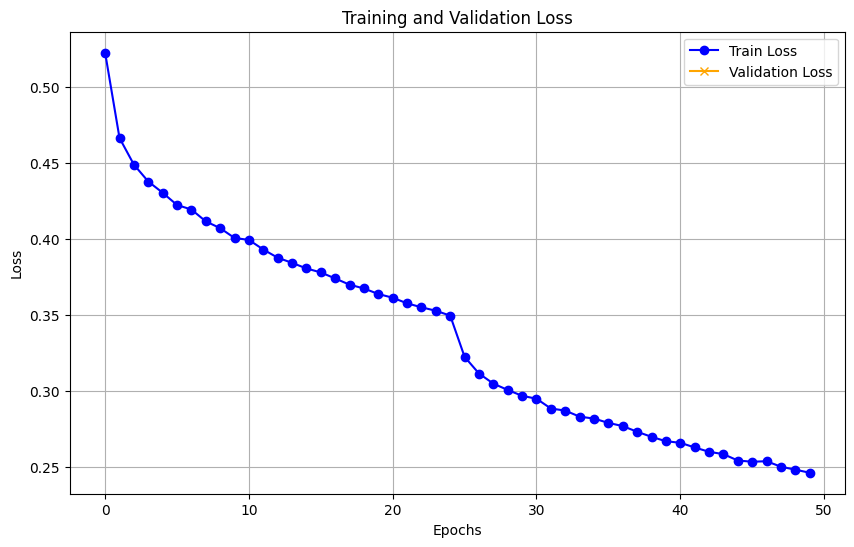

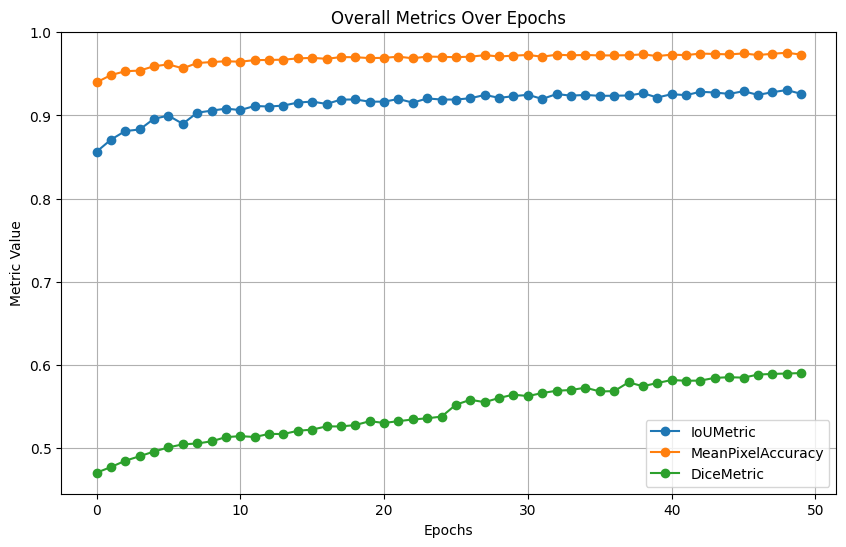

In [34]:
# Assuming train_loss, valid_loss, and overall_metrics are defined somewhere in your code
plot_losses(train_loss, valid_loss, overall_metrics)


### Visualize Prediction

/tmp/ipykernel_84351/3441765471.py:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  img = np.array(batch[idx, 0:3])  # Extract first 3 channels (assuming RGB)


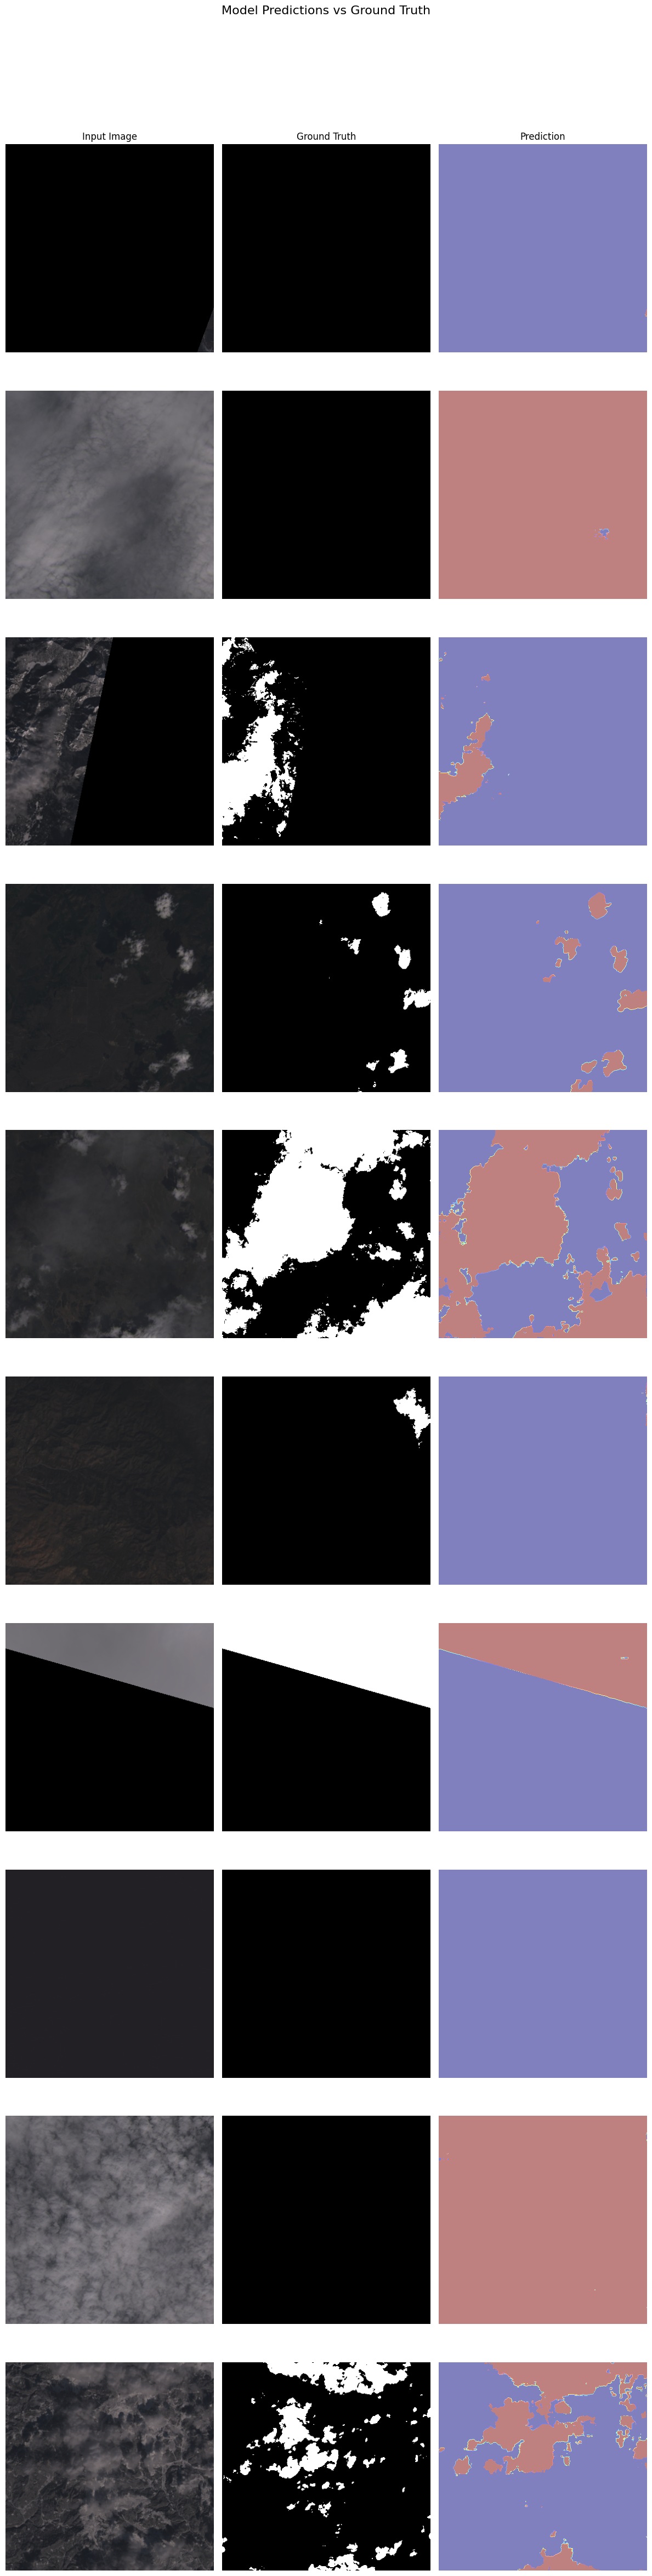

In [39]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def batch_to_img(batch, idx):
    """
    Convert a single batch item to an image format.

    Args:
    - batch: Tensor batch of shape (B, C, H, W).
    - idx: Index of the item in the batch.

    Returns:
    - img: Numpy array of the image in HWC format.
    """
    img = np.array(batch[idx, 0:3])  # Extract first 3 channels (assuming RGB)
    return img.transpose((1, 2, 0))   # Convert from CHW to HWC format

def pred_to_mask(predictions, idx):
    """
    Convert the prediction tensor to a mask.

    Args:
    - predictions: Predictions from the model.
    - idx: Index of the item in the predictions.

    Returns:
    - mask: Numpy array of the predicted mask.
    """
    # Apply softmax and take the argmax to get the predicted class
    prob_map = torch.functional.F.softmax(predictions[idx], dim=0)
    return prob_map.argmax(dim=0).cpu().numpy()  # Convert to Numpy array

# Get a batch from the validation data loader
xb, yb = next(iter(valid_dl))

# Perform predictions without tracking gradients
with torch.no_grad():
    predb = model(xb.cuda())  # Move input batch to GPU if necessary

# Visualize the results
batch_size = 10  # Number of samples to visualize
fig, ax = plt.subplots(batch_size, 3, figsize=(12, batch_size * 5))
fig.suptitle("Model Predictions vs Ground Truth", fontsize=16)

for i in range(batch_size):
    # Ensure we don't go out of bounds in case batch size is less than 10
    if i >= xb.size(0):
        break

    # Show input image, ground truth, and prediction
    ax[i, 0].imshow(batch_to_img(xb, i))
    ax[i, 1].imshow(yb[i], cmap='gray')  # Assuming yb is a grayscale mask
    ax[i, 2].imshow(pred_to_mask(predb, i), cmap='jet', alpha=0.5)  # Apply a colormap to the prediction

    # Add titles to the columns (only for the top row)
    if i == 0:
        ax[i, 0].set_title("Input Image", fontsize=12)
        ax[i, 1].set_title("Ground Truth", fontsize=12)
        ax[i, 2].set_title("Prediction", fontsize=12)

    # Remove axis ticks for cleaner display
    for j in range(3):
        ax[i, j].axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle
plt.show()


### Data Augmentation

In [52]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import random
from PIL import Image

# not working 
def get_augmentation_pipeline():
    return A.Compose([
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
        A.GridDistortion(p=0.5),
        A.RandomCrop(height=224, width=224, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.GaussianBlur(blur_limit=(3, 7), p=0.3),  # Custom blending with low cloud image
        ToTensorV2()
    ], additional_targets={'mask': 'mask'})  # Ensures mask transformations match the image

### Evaluation (is coming ...)

In [ ]:
# Load ResNet_Unet model 
model_path = "...."
model = ResNet_UNET(3, 2, pretrained=True)

# Load the model weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path, map_location=device))


In [41]:
summary(model, input_size=(3, 384, 384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 192, 192]           9,408
       BatchNorm2d-2         [-1, 64, 192, 192]             128
              ReLU-3         [-1, 64, 192, 192]               0
         MaxPool2d-4           [-1, 64, 96, 96]               0
            Conv2d-5           [-1, 64, 96, 96]          36,864
       BatchNorm2d-6           [-1, 64, 96, 96]             128
              ReLU-7           [-1, 64, 96, 96]               0
            Conv2d-8           [-1, 64, 96, 96]          36,864
       BatchNorm2d-9           [-1, 64, 96, 96]             128
             ReLU-10           [-1, 64, 96, 96]               0
       BasicBlock-11           [-1, 64, 96, 96]               0
           Conv2d-12           [-1, 64, 96, 96]          36,864
      BatchNorm2d-13           [-1, 64, 96, 96]             128
             ReLU-14           [-1, 64,